In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP
# ==========================================
# Define paths (Using os.getcwd() for notebook compatibility)
BASE_DIR = os.getcwd()
# Default to 2nd_test (4 columns), can be changed to "1st_test/1st_test" (8 columns) etc.
DATA_DIR = os.path.join(BASE_DIR, "1st_test", "1st_test")

In [17]:
# ==========================================
# 2. THE MATH (Feature Extraction)
# ==========================================
def load_and_process_data(directory):
    # List to hold the math features for every file (1 row per file)
    features_list = []
    
    # Get all files and sort them chronologically
    try:
        filenames = sorted([f for f in os.listdir(directory) if not f.startswith('.')])
    except FileNotFoundError:
        print(f"Error: The folder '{directory}' was not found.")
        return pd.DataFrame()

    print(f"Found {len(filenames)} files. Processing data signatures...")

    for filename in filenames:
        filepath = os.path.join(directory, filename)
        
        try:
            # Read the file. NASA format is usually Tab-Separated with no header.
            df_raw = pd.read_csv(filepath, sep='\t', header=None)

            # --- NEW: DOWNSAMPLE TO 100 Hz ---
            # NASA data is ~20,000 Hz. Your ESP32 is 100 Hz.
            # We keep only every 200th data point to simulate your sensor.
            df_raw = df_raw.iloc[::200, :] 
            
            # --- APPLIED MATH STEP ---
            # We compress the complex vibration wave into simple statistics.
            
            # 1. RMS (Root Mean Square) - Measures Intensity
            rms_values = np.sqrt(np.mean(df_raw**2, axis=0))
            
            # 2. Kurtosis - Measures "Spikiness" (Impacts)
            kurtosis_values = df_raw.kurtosis(axis=0)
            
            # 3. Peak - Absolute max value
            peak_values = np.max(np.abs(df_raw), axis=0)
            
            # 4. Crest Factor - Peak / RMS
            crest_factor_values = peak_values / rms_values
            
            # 5. Peak-to-Peak - Max - Min
            p2p_values = np.max(df_raw, axis=0) - np.min(df_raw, axis=0)
            
            # Create a single dictionary for this timestamp
            row = {'timestamp': filename}
            
            # Dynamic Feature Generation based on number of columns (sensors)
            num_sensors = df_raw.shape[1]
            for i in range(num_sensors):
                row[f'bearing_{i+1}_rms'] = rms_values[i]
                row[f'bearing_{i+1}_kurtosis'] = kurtosis_values[i]
                row[f'bearing_{i+1}_crest'] = crest_factor_values[i]
                row[f'bearing_{i+1}_p2p'] = p2p_values[i]
            
            features_list.append(row)
            
        except Exception as e:
            # Skip corrupted files
            continue
            
    return pd.DataFrame(features_list)

In [18]:
# Run the processing
print(f"Loading data from: {DATA_DIR}")
df = load_and_process_data(DATA_DIR)

# Only proceed if data loaded successfully
if not df.empty:
    print(f"Successfully processed {len(df)} time windows.")
    
    # Identify feature columns dynamically (excluding timestamp)
    feature_cols = [c for c in df.columns if c != 'timestamp']
    print(f"Features detected ({len(feature_cols)}): {feature_cols}")
else:
    print("No data found. Please check your DATA_DIR path.")

Loading data from: c:\Users\johne\OneDrive\Documents\GitHub\outliernodemodeltraining\1st_test\1st_test
Found 2156 files. Processing data signatures...
Successfully processed 2156 time windows.
Features detected (32): ['bearing_1_rms', 'bearing_1_kurtosis', 'bearing_1_crest', 'bearing_1_p2p', 'bearing_2_rms', 'bearing_2_kurtosis', 'bearing_2_crest', 'bearing_2_p2p', 'bearing_3_rms', 'bearing_3_kurtosis', 'bearing_3_crest', 'bearing_3_p2p', 'bearing_4_rms', 'bearing_4_kurtosis', 'bearing_4_crest', 'bearing_4_p2p', 'bearing_5_rms', 'bearing_5_kurtosis', 'bearing_5_crest', 'bearing_5_p2p', 'bearing_6_rms', 'bearing_6_kurtosis', 'bearing_6_crest', 'bearing_6_p2p', 'bearing_7_rms', 'bearing_7_kurtosis', 'bearing_7_crest', 'bearing_7_p2p', 'bearing_8_rms', 'bearing_8_kurtosis', 'bearing_8_crest', 'bearing_8_p2p']


In [19]:
# ==========================================
# 3. LABELING (Creating the Truth)
# ==========================================
# Since this is a "run-to-failure" experiment, we assume:
# First ~70% of time = Healthy (0)
# Last ~30% of time = Failing (1)

if not df.empty:
    split_point = int(len(df) * 0.7)
    
    df['status'] = 0 # Default to Healthy
    df.iloc[split_point:, df.columns.get_loc('status')] = 1 # Mark end as Failing
    
    print("Labels applied based on 70/30 time split.")

Labels applied based on 70/30 time split.


In [20]:
# ==========================================
# 4. TRAIN RANDOM FOREST
# ==========================================
if not df.empty:
    # Define inputs (X) and output (y)
    
    X = df[feature_cols]
    y = df['status']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    # Initialize and train
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    print("Model training complete.")

Model training complete.


In [21]:
# ==========================================
# 5. RESULTS
# ==========================================
if not df.empty:
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    print("-" * 30)
    print(f"Model Accuracy: {accuracy:.2%}")
    print("-" * 30)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print("(Top-Left: True Negatives, Bottom-Right: True Positives)")

------------------------------
Model Accuracy: 95.83%
------------------------------
Confusion Matrix:
[[293   4]
 [ 14 121]]
(Top-Left: True Negatives, Bottom-Right: True Positives)


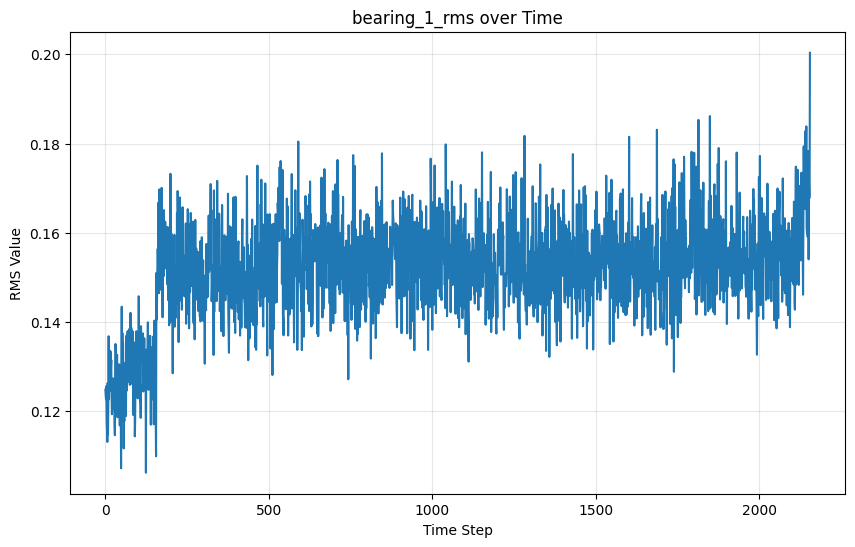

In [22]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    # Plotting the first bearing's RMS as an example
    # Check if 'bearing_1_rms' exists (it differs between 1st_test and 2nd_test datasets)
    col_to_plot = 'bearing_1_rms' if 'bearing_1_rms' in df.columns else feature_cols[0]
    
    plt.plot(df[col_to_plot])
    plt.title(f"{col_to_plot} over Time")
    plt.xlabel("Time Step")
    plt.ylabel("RMS Value")
    plt.grid(True, alpha=0.3)
    plt.show()